In [3]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim, autograd
from torch.nn import functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
from sklearn.utils import shuffle as skshuffle
from math import *
from backpack import backpack, extend
from backpack.extensions import KFAC
from sklearn.metrics import roc_auc_score
import scipy
from tqdm import tqdm, trange
import pytest
import matplotlib.pyplot as plt
from DirLPA_utils import * 

print("pytorch version: ", torch.__version__)
print("cuda available: ", torch.cuda.is_available())

s = 123
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)
torch.backends.cudnn.deterministic = True

pytorch version:  1.2.0
cuda available:  False


# Load data

In [4]:
BATCH_SIZE_TRAIN_CIFAR10 = 128
BATCH_SIZE_TEST_CIFAR10 = 128

In [9]:
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


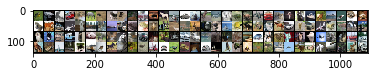

In [26]:
"""
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
"""

transform_base = [transforms.ToTensor()]

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    ] + transform_base)

transform_test = transforms.Compose(transform_base)
transform_train = transforms.RandomChoice([transform_train, transform_test])

CIFAR10_trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True, download=True, transform=transform_train)
CIFAR10_train_loader = torch.utils.data.DataLoader(CIFAR10_trainset, batch_size=BATCH_SIZE_TRAIN_CIFAR10, shuffle=True, num_workers=2)

CIFAR10_testset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False, download=True, transform=transform_test)
CIFAR10_test_loader = torch.utils.data.DataLoader(CIFAR10_testset, batch_size=BATCH_SIZE_TEST_CIFAR10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


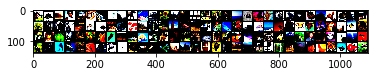

In [10]:
#load in CIFAR100
BATCH_SIZE_TRAIN_CIFAR100 = 128
BATCH_SIZE_TEST_CIFAR100 = 128

CIFAR100_train = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=True,
                                       download=True, transform=transform_train)
CIFAR100_train_loader = torch.utils.data.DataLoader(CIFAR100_train, batch_size=BATCH_SIZE_TRAIN_CIFAR100,
                                         shuffle=False)

CIFAR100_test = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=False,
                                       download=True, transform=transform_test)
CIFAR100_test_loader = torch.utils.data.DataLoader(CIFAR100_test, batch_size=BATCH_SIZE_TEST_CIFAR100,
                                         shuffle=False)

CIFAR100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

dataiter = iter(CIFAR100_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR100/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Using downloaded and verified file: /home/marius/data/SVHN/train_32x32.mat
Using downloaded and verified file: /home/marius/data/SVHN/test_32x32.mat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


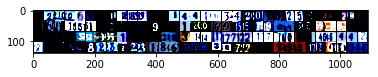

In [12]:
# load SVHN
BATCH_SIZE_TRAIN_SVHN = 128
BATCH_SIZE_TEST_SVHN = 128

train_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='train',
                             download=True, transform=transform_train)

test_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='test',
                             download=True, transform=transform_test)

SVHN_train_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TRAIN_SVHN)
SVHN_test_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TEST_SVHN)

dataiter = iter(SVHN_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_SVHN/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

# Train CIFAR10 on ResNet18 (or load weights)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os

In [13]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, num_of_channels=3):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(num_of_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x)
        out = self.linear(out)
        return out

    def features(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out


def ResNet18(num_of_channels=3, num_classes=10):
    if num_classes <= 2:
        num_classes = 1

    return ResNet(BasicBlock, [2,2,2,2],
                  num_of_channels=num_of_channels,
                  num_classes=num_classes)

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes)

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
CIFAR10_model = ResNet18().to(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CIFAR10_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

In [16]:
# Training
def train(net, epoch, optimizer, trainloader, filename):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    
    print("train loss: ", train_loss)
    print("train accuracy: ", correct/total)
    print("saving model at: {}".format(filename))
    torch.save(net.state_dict(), filename)

In [17]:
def test(net, epoch, testloader):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        print("test loss: ", test_loss)
        print("test accuracy: ", correct/total)

In [21]:
def train_all():
    CIFAR10_path = 'weights/cifar10_resnet18_SGD.pth'
    lr = 0.1
    epoch = 0
    for e in [100, 50, 50]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(CIFAR10_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(CIFAR10_model, epoch, optimizer, CIFAR10_train_loader, CIFAR10_path)
            test(CIFAR10_model, epoch, CIFAR10_test_loader)
            epoch += 1
        lr /= 10

In [22]:
#train_all()

current learning rate:  0.1

Epoch: 0


KeyboardInterrupt: 

In [28]:
##### if you already have a trained model ##############
CIFAR10_PATH = 'weights/CIFAR10_pretrained.pt'
CIFAR10_model = ResNet18().to(device)
print("loading model from: {}".format(CIFAR10_PATH))
CIFAR10_model.load_state_dict(torch.load(CIFAR10_PATH))#, map_location=torch.device('cpu')))
#test the model
test(CIFAR10_model, 0, CIFAR10_test_loader)

loading model from: weights/CIFAR10_pretrained.pt
test loss:  15.675031155347824
test accuracy:  0.9438


# prepare Gaussians (Diag and KFAC)

In [29]:
def Diag_second_order(model, train_loader, prec0 = 10, device='cpu'):

    W = list(model.parameters())[-2]
    b = list(model.parameters())[-1]
    m, n = W.shape
    print("n: {} inputs to linear layer with m: {} classes".format(n, m))
    lossfunc = torch.nn.CrossEntropyLoss()

    var0 = 1/prec0

    extend(lossfunc, debug=False)
    extend(model.linear, debug=False)

    with backpack(DiagHessian()):

        max_len = len(train_loader)
        weights_cov = torch.zeros(max_len, m, n, device=device)
        biases_cov = torch.zeros(max_len, m, device=device)

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.cuda(), y.cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                W_ = W.diag_h
                b_ = b.diag_h

                #add_prior: since it will be flattened later we can just add the prior like that
                W_ += var0 * torch.ones(W_.size(), device=device)
                b_ += var0 * torch.ones(b_.size(), device=device)


            weights_cov[batch_idx] = W_
            biases_cov[batch_idx] = b_

            print("Batch: {}/{}".format(batch_idx, max_len))

        print(len(weights_cov))
        C_W = torch.mean(weights_cov, dim=0)
        C_b = torch.mean(biases_cov, dim=0)

    # Predictive distribution
    with torch.no_grad():
        M_W_post = W.t()
        M_b_post = b

        C_W_post = C_W
        C_b_post = C_b
        
    print("M_W_post size: ", M_W_post.size())
    print("M_b_post size: ", M_b_post.size())
    print("C_W_post size: ", C_W_post.size())
    print("C_b_post size: ", C_b_post.size())

    return(M_W_post, M_b_post, C_W_post, C_b_post)

In [32]:
M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D = Diag_second_order(model=CIFAR10_model,
                                                               train_loader=CIFAR10_train_loader,
                                                               prec0 = 10,
                                                               device='cpu')

n: 512 inputs to linear layer with m: 10 classes
Batch: 0/391
Batch: 1/391
Batch: 2/391
Batch: 3/391
Batch: 4/391
Batch: 5/391
Batch: 6/391
Batch: 7/391
Batch: 8/391
Batch: 9/391
Batch: 10/391
Batch: 11/391
Batch: 12/391
Batch: 13/391
Batch: 14/391
Batch: 15/391
Batch: 16/391
Batch: 17/391
Batch: 18/391
Batch: 19/391
Batch: 20/391
Batch: 21/391
Batch: 22/391
Batch: 23/391
Batch: 24/391
Batch: 25/391
Batch: 26/391
Batch: 27/391
Batch: 28/391
Batch: 29/391
Batch: 30/391
Batch: 31/391
Batch: 32/391
Batch: 33/391
Batch: 34/391
Batch: 35/391
Batch: 36/391
Batch: 37/391
Batch: 38/391
Batch: 39/391
Batch: 40/391
Batch: 41/391
Batch: 42/391
Batch: 43/391
Batch: 44/391
Batch: 45/391
Batch: 46/391
Batch: 47/391
Batch: 48/391
Batch: 49/391
Batch: 50/391
Batch: 51/391
Batch: 52/391
Batch: 53/391
Batch: 54/391
Batch: 55/391
Batch: 56/391
Batch: 57/391
Batch: 58/391
Batch: 59/391
Batch: 60/391
Batch: 61/391
Batch: 62/391
Batch: 63/391
Batch: 64/391
Batch: 65/391
Batch: 66/391
Batch: 67/391
Batch: 68

In [ ]:
def KFLP_second_order(model, train_loader, prec0 = 10, device='cpu'):

    W = list(model.parameters())[-2]
    b = list(model.parameters())[-1]
    m, n = W.shape
    lossfunc = torch.nn.CrossEntropyLoss()

    var0 = 1/prec0

    extend(lossfunc, debug=False)
    extend(model.linear, debug=False)

    with backpack(KFAC()):
        U, V = torch.zeros(m, m, device=device), torch.zeros(n, n, device=device)
        B = torch.zeros(m, m, device=device)

        max_len = int(np.ceil(len(train_loader.dataset)/batch_size))
        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.cuda(), y.cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                U_, V_ = W.kfac
                B_ = b.kfac[0]

                U_ = np.sqrt(batch_size)*U_ + np.sqrt(var0)*torch.eye(m, device=device)
                V_ = np.sqrt(batch_size)*V_ + np.sqrt(var0)*torch.eye(n, device=device)
                B_ = batch_size*B_ + var0*torch.eye(m, device=device)

                rho = min(1-1/(batch_idx+1), 0.95)

                U = rho*U + (1-rho)*U_
                V = rho*V + (1-rho)*V_
                B = rho*B + (1-rho)*B_

            print("Batch: {}/{}".format(batch_idx, max_len))


    # Predictive distribution
    with torch.no_grad():
        M_W_post = W.t()
        M_b_post = b

        # Covariances for Laplace
        U_post = torch.inverse(V)  # Interchanged since W is transposed
        V_post = torch.inverse(U)
        B_post = torch.inverse(B)

    return(M_W_post, M_b_post, U_post, V_post, B_post)

In [ ]:
M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K = KFLP_second_order(model=CIFAR10_model,
                                                               train_loader=CIFAR10_train_loader,
                                                               prec0 = 10,
                                                               device='cpu')

In [21]:
def get_Gaussian_output(x, mu_w, mu_b, sigma_w, sigma_b):
    #get the distributions per class
    batch_size = x.size(0)
    num_classes = mu_b.size(0)
    
    # get mu batch
    mu_w_batch = mu_w.repeat(batch_size, 1, 1)
    mu_b_batch = mu_b.repeat(batch_size, 1)
    mu_batch = torch.bmm(x.view(batch_size, 1, -1), mu_w_batch).view(batch_size, -1) + mu_b_batch
    
    #get sigma batch
    sigma_w_batch = sigma_w.repeat(batch_size, 1, 1)
    sigma_b_batch = sigma_b.repeat(batch_size, 1)
    sigmas_diag = torch.zeros(batch_size, num_classes, device='cuda')
    for j in range(num_classes):
        h1 = x * sigma_w_batch[:, j]
        helper = torch.matmul(h1.view(batch_size, 1, -1), x.view(batch_size, -1, 1))
        helper = helper.view(-1) + sigma_b_batch[:,j]
        sigmas_diag[:,j] = helper
        
    sigma_batch = torch.stack([torch.diag(x) for x in sigmas_diag])

    
    return(mu_batch, sigma_batch)


In [22]:
@torch.no_grad()
def predict_diagonal_sampling(model, test_loader, M_W_post, M_b_post, C_W_post, C_b_post, n_samples, verbose=False, cuda=False, timing=False):
    py = []
    max_len = len(test_loader)
    if timing:
        time_sum = 0

    for batch_idx, (x, y) in enumerate(test_loader):

        if cuda:
            x, y = x.cuda(), y.cuda()

        phi = model.phi(x)

        mu, Sigma = get_Gaussian_output(phi, M_W_post, M_b_post, C_W_post, C_b_post)
        #print("mu size: ", mu.size())
        #print("sigma size: ", Sigma.size())

        post_pred = MultivariateNormal(mu, Sigma)

        # MC-integral
        t0 = time.time()
        py_ = 0

        for _ in range(n_samples):
            f_s = post_pred.rsample()
            py_ += torch.softmax(f_s, 1)

        py_ /= n_samples
        py_ = py_.detach()

        py.append(py_)
        t1 = time.time()
        if timing:
            time_sum += (t1 - t0)

        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))

    if timing: print("time used for sampling with {} samples: {}".format(n_samples, time_sum))
    
    return torch.cat(py, dim=0)

In [ ]:
def predict_KFAC_sampling(model, test_loader, M_W_post, M_b_post, U_post, V_post, B_post, n_samples, verbose=False, cuda=False):
    py = []
    max_len = len(test_loader)
    if timing:
        time_sum = 0

    for batch_idx, (x, y) in enumerate(test_loader):

        if cuda:
            x, y = x.cuda(), y.cuda()

        phi = model.phi(x)

        mu_pred = phi @ M_W_post + M_b_post
        Cov_pred = torch.diag(phi @ U_post @ phi.t()).reshape(-1, 1, 1) * V_post.unsqueeze(0) + B_post.unsqueeze(0)

        post_pred = MultivariateNormal(mu_pred, Cov_pred)

        # MC-integral
        t0 = time.time()
        py_ = 0

        for _ in range(n_samples):
            f_s = post_pred.rsample()
            py_ += torch.softmax(f_s, 1)

        py_ /= n_samples
        py_ = py_.detach()

        py.append(py_)
        if timing:
            time_sum += (t1 - t0)


        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))
            
    if timing: print("time used for sampling with {} samples: {}".format(n_samples, time_sum))

    return torch.cat(py, dim=0)

In [32]:
def get_alpha_from_Normal(mu, Sigma):
    batch_size, K = mu.size(0), mu.size(-1)
    Sigma_d = torch.diagonal(Sigma, dim1=1, dim2=2)
    sum_exp = torch.sum(torch.exp(-1*mu), dim=1).view(-1,1)
    alpha = 1/Sigma_d * (1 - 2/K + torch.exp(mu)/K**2 * sum_exp)
    
    return(alpha)

In [33]:
@torch.no_grad()
def predict_LB(model, test_loader, M_W_post, M_b_post, C_W_post, C_b_post, verbose=False, cuda=False, timing=False):
    alphas = []
    if timing:
        time_sum = 0

    max_len = int(np.ceil(len(test_loader.dataset)/len(test_loader)))

    for batch_idx, (x, y) in enumerate(test_loader):
        
        if cuda:
            x, y = x.cuda(), y.cuda()

        phi = model.phi(x)

        mu_pred, Cov_pred = get_Gaussian_output(phi, M_W_post, M_b_post, C_W_post, C_b_post)
        
        t0 = time.time()
        alpha = get_alpha_from_Normal(mu_pred, Cov_pred).detach()
        t1 = time.time()
        if timing:
            time_sum += (t1-t0)

        alphas.append(alpha)

        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))

    if timing:
        print("total time used for transform: {:.05f}".format(time_sum))
    
    return(torch.cat(alphas, dim = 0))

In [23]:
targets_CIFAR10 = testset.targets
targets_CIFAR100 = CIFAR100_test.targets
targets_SVHN = []
for x,y in test_loader_SVHN:
    targets_SVHN.append(y)
targets_SVHN = torch.cat(targets_SVHN).numpy()

In [19]:
def get_in_dist_values(py_in, targets):
    acc_in = np.mean(np.argmax(py_in, 1) == targets)
    prob_correct = py_in[targets].mean()
    average_entropy = -np.sum(py_in*np.log(py_in+1e-8), axis=1).mean()
    MMC = py_in.max(1).mean()
    return(acc_in, prob_correct, average_entropy, MMC)

def get_out_dist_values(py_in, py_out, targets):
    average_entropy = -np.sum(py_out*np.log(py_out+1e-8), axis=1).mean()
    acc_out = np.mean(np.argmax(py_out, 1) == targets)
    if max(targets) > len(py_in[0]):
        targets = np.array(targets)
        targets[targets >= len(py_in[0])] = 0
    #prob_correct = np.choose(targets, py_out.T).mean()
    prob_correct = py_out[targets].mean()
    labels = np.zeros(len(py_in)+len(py_out), dtype='int32')
    labels[:len(py_in)] = 1
    examples = np.concatenate([py_in.max(1), py_out.max(1)])
    auroc = roc_auc_score(labels, examples)
    MMC = py_out.max(1).mean()
    return(acc_out, prob_correct, average_entropy, MMC, auroc)

In [ ]:
def print_in_dist_values(acc_in, prob_correct, average_entropy, MMC, train='mnist', method='KFAC'):

    print(f'[In, {method}, {train}] Accuracy: {acc_in:.3f}; average entropy: {average_entropy:.3f}; \
    MMC: {MMC:.3f}; Prob @ correct: {prob_correct:.3f}')


def print_out_dist_values(acc_out, prob_correct, average_entropy, MMC, auroc, train='mnist', test='FMNIST', method='KFAC'):

    print(f'[Out-{test}, {method}, {train}] Accuracy: {acc_out:.3f}; Average entropy: {average_entropy:.3f};\
    MMC: {MMC:.3f}; AUROC: {auroc:.3f}; Prob @ correct: {prob_correct:.3f}')

# MAP estimate

In [24]:
CIFAR10_test_in_MAP = predict_MAP(CIFAR10_model, testloader, cuda=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_MAP = predict_MAP(CIFAR10_model, CIFAR100_test_loader, cuda=True).cpu().numpy()
CIFAR10_test_out_SVHN_MAP = predict_MAP(CIFAR10_model, test_loader_SVHN, cuda=True).cpu().numpy()

In [25]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(CIFAR10_test_in_MAP, targets_CIFAR10)
acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP = get_out_dist_values(CIFAR10_test_in_MAP, CIFAR10_test_out_CIFAR100_MAP, targets_CIFAR100)
acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP = get_out_dist_values(CIFAR10_test_in_MAP, CIFAR10_test_out_SVHN_MAP, targets_SVHN)

In [26]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'CIFAR10', 'MAP')
print_out_dist_values(acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP, 'CIFAR100', 'MAP')
print_out_dist_values(acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP, 'SVHN', 'MAP')

[In, MAP, CIFAR10] Accuracy: 0.952; average entropy: 0.066;     MMC: 0.979; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR100] Accuracy: 0.009; Average entropy: 0.497;    MMC: 0.828; AUROC: 0.874; Prob @ correct: 0.100
[Out-MAP, KFAC, SVHN] Accuracy: 0.112; Average entropy: 0.604;    MMC: 0.793; AUROC: 0.925; Prob @ correct: 0.100


In [86]:
#MAP estimate
#seeds are 123,124,125,126,127
acc_in = [0.953, 0.952, 0.952, 0.950, 0.952]
mmc_in = [0.979, 0.978, 0.979, 0.976, 0.979]
mmc_out_CIFAR100 = [0.831, 0.827, 0.829, 0.827, 0.828]
mmc_out_SVHN = [0.721, 0.809, 0.780, 0.784, 0.793]

auroc_out_CIFAR100 = [0.872, 0.877, 0.874, 0.864, 0.874]
auroc_out_SVHN = [0.939, 0.919, 0.927, 0.917, 0.925]

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

accuracy: 0.952 with std 0.001
MMC in: 0.978 with std 0.001
MMC out CIFAR100: 0.828 with std 0.001
MMC out SVHN: 0.777 with std 0.030
AUROC out CIFAR100: 0.872 with std 0.004
AUROC out SVHN: 0.925 with std 0.008


# Diagonal estimate

In [28]:
CIFAR10_test_in_D = predict_diagonal_sampling(CIFAR10_model, testloader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=1000, cuda=True, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_D = predict_diagonal_sampling(CIFAR10_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=1000, cuda=True, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_D = predict_diagonal_sampling(CIFAR10_model, test_loader_SVHN, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=1000, cuda=True, timing=True).cpu().numpy()

time used for sampling with 1000 samples: 6.642724990844727
time used for sampling with 1000 samples: 6.6236491203308105
time used for sampling with 1000 samples: 17.064507722854614


In [29]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(CIFAR10_test_in_D, targets_CIFAR10)
acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D = get_out_dist_values(CIFAR10_test_in_D, CIFAR10_test_out_CIFAR100_D, targets_CIFAR100)
acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D = get_out_dist_values(CIFAR10_test_in_D, CIFAR10_test_out_SVHN_D, targets_SVHN)

In [30]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'CIFAR10', 'Diag')
print_out_dist_values(acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D, 'CIFAR100', 'Diag')
print_out_dist_values(acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D, 'SVHN', 'Diag')

[In, Diag, CIFAR10] Accuracy: 0.952; average entropy: 0.194;     MMC: 0.950; Prob @ correct: 0.100
[Out-Diag, KFAC, CIFAR100] Accuracy: 0.009; Average entropy: 0.497;    MMC: 0.724; AUROC: 0.884; Prob @ correct: 0.100
[Out-Diag, KFAC, SVHN] Accuracy: 0.112; Average entropy: 0.971;    MMC: 0.674; AUROC: 0.931; Prob @ correct: 0.100


In [85]:
#Diag Sampling
#seeds are 123,124,125,126,127
time_lpb_in = [6.636955976486206, 6.716174125671387, 6.57476282119751, 6.605843544006348, 6.642724990844727]
time_lpb_out_CIFAR100 = [6.614115238189697, 6.61441969871521, 6.560410737991333, 6.474161148071289, 6.6236491203308105]
time_lpb_out_SVHN = [17.011831521987915, 17.094997882843018, 17.031347036361694,16.71169662475586, 17.064507722854614]

acc_in = [0.953, 0.952, 0.952, 0.950, 0.952]
mmc_in = [0.950, 0.950, 0.950, 0.947, 0.950]
mmc_out_CIFAR100 = [0.727, 0.721, 0.725, 0.724, 0.724]
mmc_out_SVHN = [0.605, 0.685, 0.661, 0.672, 0.674]

auroc_out_CIFAR100 = [0.884, 0.889, 0.885, 0.876, 0.884]
auroc_out_SVHN = [0.943, 0.927, 0.933, 0.921, 0.931]

print("Sampling Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Sampling Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))
print("Sampling Bridge time out SVHN: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Sampling Bridge time in: 6.635 with std 0.047
Sampling Bridge time out CIFAR100: 6.577 with std 0.056
Sampling Bridge time out SVHN: 16.983 with std 0.139
accuracy: 0.952 with std 0.001
MMC in: 0.949 with std 0.001
MMC out CIFAR100: 0.724 with std 0.002
MMC out SVHN: 0.659 with std 0.028
AUROC out CIFAR100: 0.884 with std 0.004
AUROC out SVHN: 0.931 with std 0.007


# KFAC estimate

In [ ]:
CIFAR10_test_in_K = predict_KFAC_sampling(CIFAR10_model, CIFAR10_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, n_samples=1000, cuda=True, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_K = predict_KFAC_sampling(CIFAR10_model, CIFAR100_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, n_samples=1000, cuda=True, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_K = predict_KFAC_sampling(CIFAR10_model, SVHN_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, n_samples=1000, cuda=True, timing=True).cpu().numpy()

In [ ]:
acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K = get_in_dist_values(CIFAR10_test_in_K, targets_CIFAR10)
acc_out_CIFAR100_K, prob_correct_out_CIFAR100_K, ent_out_CIFAR100_K, MMC_out_CIFAR100_K, auroc_out_CIFAR100_K = get_out_dist_values(CIFAR10_test_in_K, CIFAR10_test_out_CIFAR100_K, targets_CIFAR100)
acc_out_SVHN_K, prob_correct_out_SVHN_K, ent_out_SVHN_K, MMC_out_SVHN_K, auroc_out_SVHN_K = get_out_dist_values(CIFAR10_test_in_K, CIFAR10_test_out_SVHN_K, targets_SVHN)

In [ ]:
print_in_dist_values(acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K, 'CIFAR10', 'KFAC')
print_out_dist_values(acc_out_CIFAR100_K, prob_correct_out_CIFAR100_K, ent_out_CIFAR100, MMC_out_CIFAR100_K, auroc_out_CIFAR100_K, 'CIFAR100', 'KFAC')
print_out_dist_values(acc_out_SVHN_K, prob_correct_out_SVHN_K, ent_out_SVHN_K, MMC_out_SVHN_K, auroc_out_SVHN_K, 'SVHN', 'KFAC')

In [ ]:
#KFAC approximation of the Hessian
#seeds are 123,124,125,126,127
time_lpb_in = []
time_lpb_out_CIFAR100 = []
time_lpb_out_SVHN = []


acc_in = []
mmc_in = []
mmc_out_CIFAR100 = []
mmc_out_SVHN = []


auroc_out_CIFAR100 = []
auroc_out_SVHN = []


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))
print("Laplace Bridge time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

# Laplace Bridge estimate

In [34]:
CIFAR10_test_in_LB = predict_LB(CIFAR10_model, CIFAR10_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=True, verbose=False, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_LB = predict_LB(CIFAR10_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=True, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_LB = predict_LB(CIFAR10_model, SVHN_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=True, timing=True).cpu().numpy()

total time used for transform: 0.01773
total time used for transform: 0.01598
total time used for transform: 0.04112


In [35]:
#normalize to get the MAP estimate (which is the mode) of the Dirichlet
CIFAR10_test_in_LBn = CIFAR10_test_in_LB/CIFAR10_test_in_LB.sum(1).reshape(-1,1)
CIFAR10_test_out_CIFAR100_LBn = CIFAR10_test_out_CIFAR100_LB/CIFAR10_test_out_CIFAR100_LB.sum(1).reshape(-1,1)
CIFAR10_test_out_SVHN_LBn = CIFAR10_test_out_SVHN_LB/CIFAR10_test_out_SVHN_LB.sum(1).reshape(-1,1)

In [36]:
acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB = get_in_dist_values(CIFAR10_test_in_LBn, targets_CIFAR10)
acc_out_CIFAR100_DIR_LPA, prob_correct_out_CIFAR100_DIR_LPA, ent_out_CIFAR100_LB, MMC_out_CIFAR100_DIR_LPA, auroc_out_CIFAR100_LB = get_out_dist_values(CIFAR10_test_in_LBn, CIFAR10_test_out_CIFAR100_LBn, targets_CIFAR100)
acc_out_SVHN_LB, prob_correct_out_SVHN_LB, ent_out_SVHN_LB, MMC_out_SVHN_LB, auroc_out_SVHN_LB = get_out_dist_values(CIFAR10_test_in_LBn, CIFAR10_test_out_SVHN_LBn, targets_SVHN)

In [33]:
print_in_dist_values(acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB, 'CIFAR10', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB, 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_SVHN_LB, prob_correct_out_SVHN_LB, ent_out_SVHN_LB, MMC_out_SVHN_LB, auroc_out_SVHN_LB, 'SVHN', 'Laplace Bridge')

NameError: name 'acc_in_LB' is not defined


182042624it [24:44:37, 2043.65it/s]
64282624it [24:43:57, 721.97it/s]


In [ ]:
#Laplace Bridge
#seeds are 123,124,125,126,127
time_lpb_in = [0.01729, 0.01750, 0.01749,0.01724, 0.01773]
time_lpb_out_CIFAR100 = [0.01571,0.01601, 0.01570, 0.01580, 0.01598]
time_lpb_out_SVHN = [0.04075, 0.04107, 0.04046, 0.04067, 0.04112]


acc_in = [0.953, 0.952, 0.952, 0.950, 0.952]
mmc_in = [0.971, 0.970, 0.970, 0.966, 0.970]
mmc_out_CIFAR100 = [0.779, 0.774, 0.775, 0.771, 0.771]
mmc_out_SVHN = [0.639, 0.747, 0.719, 0.698, 0.715]


auroc_out_CIFAR100 = [0.856, 0.863, 0.859, 0.852, 0.862]
auroc_out_SVHN = [0.935, 0.912, 0.923, 0.919, 0.925]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))
print("Laplace Bridge time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

In [ ]:
# check if condition holds

def check_condition(alpha_vecs):
    #note that this is vectorized
    alpha_sum = alpha_vecs.sum(1)
    alpha_max = alpha_vecs.max(1)
    alpha_sum_minus = alpha_sum - alpha_max
    right_side = 0.25 * (np.sqrt(9 * alpha_sum_minus**2 + 10 * alpha_sum_minus + 1) - alpha_sum_minus - 1)
    cases = alpha_max > right_side
    percentage = np.sum(cases)/len(cases)
    return(percentage)

In [ ]:
print(np.sum(check_condition(CIFAR10_test_in_LB)))
print(np.sum(check_condition(CIFAR10_test_out_CIFAR100_LB)))
print(np.sum(check_condition(CIFAR10_test_out_SVHN_LB)))